In [61]:
# sometime jaxtyping doesn't install correctly,
# just restart and try again in that case (:
%pip install einops
%pip install jaxtyping
%pip install transformers fschat livelossplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befor

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, GPTNeoXForCausalLM
from fastchat.conversation import Conversation, get_conv_template
from livelossplot import PlotLosses
from jaxtyping import Int, Float
from typing import Tuple, List, Optional, Dict
from llm_attacks.minimal_gcg.string_utils import SuffixManager, load_conversation_template

In [5]:
# from suffix_attack import *
import torch
import einops
import gc

ipython = get_ipython()
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

def clear_gpu_mem():
    gc.collect()
    torch.cuda.empty_cache()


/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_1109/752335641.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_1109/752335641.py:8: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


### The code for the suffix attack

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, GPTNeoXForCausalLM
from fastchat.conversation import Conversation, get_conv_template
from livelossplot import PlotLosses
from jaxtyping import Int, Float
from typing import Tuple, List, Optional, Dict

device = "cpu"
non_mps_device = "cpu"
model_name = "pythia"
auth_token = ""
precision = torch.float32

class SuffixManager:
    def __init__(self, *, tokenizer, conv_template: Conversation, instruction: str, target: str, adv_string: List[int]):

        self.tokenizer = tokenizer
        self.conv_template = conv_template
        self.instruction = instruction
        self.target = target
        self.adv_string = adv_string

    def get_prompt(self, adv_string=None):

        if adv_string is not None:
            self.adv_string = adv_string

        self.conv_template.append_message(self.conv_template.roles[0], f"{self.instruction} {self.adv_string}")
        self.conv_template.append_message(self.conv_template.roles[1], f"{self.target}")
        prompt = self.conv_template.get_prompt()

        encoding = self.tokenizer(prompt)
        toks = encoding.input_ids

        if self.conv_template.name == 'llama-2':
            self.conv_template.messages = []

            self.conv_template.append_message(self.conv_template.roles[0], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._user_role_slice = slice(None, len(toks))

            self.conv_template.update_last_message(f"{self.instruction}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._goal_slice = slice(self._user_role_slice.stop, max(self._user_role_slice.stop, len(toks)))

            separator = ' ' if self.instruction else ''
            self.conv_template.update_last_message(f"{self.instruction}{separator}{self.adv_string}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._control_slice = slice(self._goal_slice.stop, len(toks))

            self.conv_template.append_message(self.conv_template.roles[1], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._assistant_role_slice = slice(self._control_slice.stop, len(toks))

            self.conv_template.update_last_message(f"{self.target}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._target_slice = slice(self._assistant_role_slice.stop, len(toks)-2)
            self._loss_slice = slice(self._assistant_role_slice.stop-1, len(toks)-3)

        elif self.conv_template.name == 'oasst_pythia':
            # This is specific to the vicuna and pythia tokenizer and conversation prompt.
            # It will not work with other tokenizers or prompts.
            self.conv_template.messages = []

            self.conv_template.append_message(self.conv_template.roles[0], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._user_role_slice = slice(None, len(toks))

            self.conv_template.update_last_message(f"{self.instruction}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._goal_slice = slice(self._user_role_slice.stop, max(self._user_role_slice.stop, len(toks)-1))

            separator = ' ' if self.instruction else ''
            self.conv_template.update_last_message(f"{self.instruction}{separator}{self.adv_string}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._control_slice = slice(self._goal_slice.stop, len(toks)-1)

            self.conv_template.append_message(self.conv_template.roles[1], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._assistant_role_slice = slice(self._control_slice.stop, len(toks))

            self.conv_template.update_last_message(f"{self.target}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._target_slice = slice(self._assistant_role_slice.stop, len(toks)-1)
            self._loss_slice = slice(self._assistant_role_slice.stop-1, len(toks)-2)
        else:
            assert False, "Conversation template not supported"

        self.conv_template.messages = []

        return prompt

    def get_input_ids(self, adv_string=None):
        prompt = self.get_prompt(adv_string=adv_string)
        toks = self.tokenizer(prompt).input_ids
        input_ids = torch.tensor(toks[:self._target_slice.stop])

        return input_ids

    # def get_batch_input_ids(self, adv)




# support for different models:
# 1) A very small one such as pythia 70m to do fast stuff
# 2) Llama2
# 3) Ideally an arbitrary hf model with the same tokenizer as llama
def get_model_and_tokenizer(model_path="EleutherAI/pythia-1.4b", tokenizer_path="EleutherAI/pythia-1.4b", **kwargs):
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=precision,
        trust_remote_code=True,
        use_auth_token=auth_token
    ).to(device)

    if 'llama-2' in model_path:
        use_fast = False
    elif 'pythia' in model_path:
        use_fast = True

    tokenizer = AutoTokenizer.from_pretrained(
        tokenizer_path,
        trust_remote_code=True,
        use_fast=use_fast
    )

    # I don't really know why we do this
    if 'llama-2' in model_path:
        tokenizer.pad_token = tokenizer.unk_token
        tokenizer.padding_side = 'left'
    elif 'pythia' in model_path:
        tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer


def token_gradients(model, input_ids, input_slice, target_slice, loss_slice):
    if isinstance(model, LlamaForCausalLM):
        embed_weights = model.model.embed_tokens.weight
        embeds = model.model.embed_tokens(input_ids).detach()
    elif isinstance(model, GPTNeoXForCausalLM):
        embed_weights = model.base_model.embed_in.weight
        embeds = model.base_model.embed_in(input_ids.unsqueeze(0).to(device)).detach()
    else:
        assert False, "Only Llama and GPTNeoX models are supported"

    one_hot = torch.zeros(
        input_ids[input_slice].shape[0],
        embed_weights.shape[0],
        dtype=embed_weights.dtype
    ).to(device)

    # maybe use scatter here?
    one_hot[torch.arange(input_ids[input_slice].shape[0]),input_ids[input_slice]] = 1.0

    # this returns an error when run on MPS
    #one_hot = torch.zeros(
    #    input_ids[input_slice].shape[0],
    #    embed_weights.shape[0],
    #    device='cpu',
    #    dtype=embed_weights.dtype
    #)
    #one_hot = one_hot_cpu.scatter(
    #    1,
    #    input_ids[input_slice].unsqueeze(1),
    #    torch.ones(one_hot_cpu.shape[0], 1, device=model.device, dtype=embed_weights.dtype)
    #)

    #print(f"One-hot shape is {one_hot.shape}")
    #print(f"Embed matrix has shape {embed_weights.shape}")

    one_hot.requires_grad_()
    #input_embeds = (one_hot @ embed_weights).unsqueeze(0)

    #print(f"Input embeds were computed")

    # now stitch it together with the rest of the embeddings
    #embeds = get_embeddings(model, input_ids.unsqueeze(0)).detach()


    full_embeds = torch.cat(
        [
            embeds[:,:input_slice.start,:],
            (one_hot @ embed_weights).unsqueeze(0),
            embeds[:,input_slice.stop:,:]
        ],
        dim=1
    ).to(device)

    #print(f"Stiched embeddings")

    #print(f"Stiched embeddings have type {full_embeds.dtype}")
    #print(f"Should have type {embeds.dtype}")

    #print(f"Shape of full embeds is: {full_embeds.shape}")

    logits = model(inputs_embeds=full_embeds).logits

    #print("Compute the forward pass")

    #logits = model(inputs_embeds=full_embeds).logits

    #print(f"Gotten logits {logits.shape}")

    targets = input_ids[target_slice].to(device)

    loss = nn.CrossEntropyLoss()(logits[0,loss_slice,:], targets)

    #print(f"Forward pass")

    loss.backward()

    grad = one_hot.grad.clone()
    grad = grad / grad.norm(dim=-1, keepdim=True)

    # should we do this?
    model.zero_grad()

    return grad


# selects k tokens within the topk (allowed) control tokens
def sample_control(
    control_toks,
    grad,
    batch_size,
    topk=256,
    temp=1,
    not_allowed_tokens=None
):

    if not_allowed_tokens is not None:
        grad[:, not_allowed_tokens.to(grad.device)] = np.infty

    top_indices = (-grad).topk(topk, dim=1).indices
    control_toks = control_toks.to(grad.device)

    original_control_toks = control_toks.repeat(batch_size, 1)
    new_token_pos = torch.arange(
        0,
        len(control_toks),
        len(control_toks) / batch_size,
        device=grad.device
    ).type(torch.int64)
    new_token_val = torch.gather(
        top_indices[new_token_pos], 1,
        torch.randint(0, topk, (batch_size, 1),
        device=grad.device)
    )
    new_control_toks = original_control_toks.scatter_(1, new_token_pos.unsqueeze(-1), new_token_val)

    return new_control_toks

# control_cand - are the topk loss minimizing replacements
# we found for every token in the control slice
def get_filtered_cands(
    tokenizer,
    control_cand: Int[Tensor, "batch_size"],
    filter_cand=True,
    curr_control=None
) -> List[str]:
    """
    Filters invalid candidates from a set of control codes.

    Parameters
    ----------
    tokenizer : Tokenizer
        Tokenizer to decode candidates.
    control_cand : torch.Tensor
        Candidate control codes.
    filter_cand : bool, optional
        Whether to filter candidates.
    curr_control : str, optional
        Current control code.

    Returns
    -------
    list
        List of filtered valid candidate strings.
    """
    cands, count = [], 0
    for i in range(control_cand.shape[0]):
        decoded_str = tokenizer.decode(control_cand[i], skip_special_tokens=True)
        if filter_cand:
            if decoded_str != curr_control and len(tokenizer(decoded_str, add_special_tokens=False).input_ids) == len(control_cand[i]):
                cands.append(decoded_str)
            else:
                count += 1
        else:
            cands.append(decoded_str)

    #print(f"Cands are {cands}")
    #print(f"Counts are {count}")

    if filter_cand:
        cands = cands + [cands[-1]] * (len(control_cand) - len(cands))
        # print(f"Warning: {round(count / len(control_cand), 2)} control candidates were not valid")
    return cands


# input_ids - original input tokens
# control_slice - the slice of input ids to replace (like the I in the paper)
# test_controls - control code strings to substitute? supposedly the str tokens?
# return_ids - whether to return or not the modified ids of the new tokens
def get_logits(*, model, tokenizer, input_ids, control_slice, test_controls=None, return_ids=False, batch_size=512):
    """
    Evaluates model on inputs with injected control codes.

    Parameters
    ----------
    model : nn.Module
        Model to evaluate.
    tokenizer : Tokenizer
        Tokenizer to encode controls.
    input_ids : torch.Tensor
        Original input IDs.
    control_slice : slice
        Slice of input to replace.
    test_controls : list, optional
        Control codes to inject.
    return_ids : bool, optional
        Whether to return modified IDs.
    batch_size : int, optional
        Evaluation batch size.

    Returns
    -------
    torch.Tensor
        Logits from model on modified inputs.
    """

    if isinstance(test_controls[0], str):
        max_len = control_slice.stop - control_slice.start
        test_ids = [
            torch.tensor(tokenizer(control, add_special_tokens=False).input_ids[:max_len], device=non_mps_device)
            for control in test_controls
        ]
        pad_tok = 0
        while pad_tok in input_ids or any([pad_tok in ids for ids in test_ids]):
            pad_tok += 1
        nested_ids = torch.nested.nested_tensor(test_ids)
        test_ids = torch.nested.to_padded_tensor(nested_ids, pad_tok, (len(test_ids), max_len))
    else:
        raise ValueError(f"test_controls must be a list of strings, got {type(test_controls)}")

    if not(test_ids[0].shape[0] == control_slice.stop - control_slice.start):
        raise ValueError((
            f"test_controls must have shape "
            f"(n, {control_slice.stop - control_slice.start}), "
            f"got {test_ids.shape}"
        ))


    locs = torch.arange(control_slice.start, control_slice.stop).repeat(test_ids.shape[0], 1).to(model.device)
    ids = torch.scatter(
        input_ids.unsqueeze(0).repeat(test_ids.shape[0], 1).to(model.device),
        1,
        locs,
        test_ids
    )
    if pad_tok >= 0:
        attn_mask = (ids != pad_tok).type(ids.dtype)
    else:
        attn_mask = None

    if return_ids:
        del locs, test_ids ; gc.collect()
        return forward(model=model, input_ids=ids, attention_mask=attn_mask, batch_size=batch_size), ids
    else:
        del locs, test_ids
        logits = forward(model=model, input_ids=ids, attention_mask=attn_mask, batch_size=batch_size)
        del ids ; gc.collect()
        return logits


def target_loss(logits, ids, target_slice):
    crit = nn.CrossEntropyLoss(reduction='none')
    loss_slice = slice(target_slice.start-1, target_slice.stop-1)
    loss = crit(logits[:,loss_slice,:].transpose(1,2), ids[:,target_slice])
    return loss.mean(dim=-1)


# what is the "*"?
def forward(*, model, input_ids, attention_mask, batch_size=512):

    logits = []
    for i in range(0, input_ids.shape[0], batch_size):

        batch_input_ids = input_ids[i:i+batch_size]
        if attention_mask is not None:
            batch_attention_mask = attention_mask[i:i+batch_size]
        else:
            batch_attention_mask = None

        logits.append(model(input_ids=batch_input_ids, attention_mask=batch_attention_mask).logits)

        gc.collect()

    del batch_input_ids, batch_attention_mask

    return torch.cat(logits, dim=0)


class SuffixManager:
    def __init__(self, tokenizer, conv_template: Conversation, instruction: str, target: str, adv_string: List[int]):

        self.tokenizer = tokenizer
        self.conv_template = conv_template
        self.instruction = instruction
        self.target = target
        self.adv_string = adv_string

    def get_prompt(self, adv_string=None):

        if adv_string is not None:
            self.adv_string = adv_string

        self.conv_template.append_message(self.conv_template.roles[0], f"{self.instruction} {self.adv_string}")
        self.conv_template.append_message(self.conv_template.roles[1], f"{self.target}")
        prompt = self.conv_template.get_prompt()

        encoding = self.tokenizer(prompt)
        toks = encoding.input_ids

        if self.conv_template.name == 'llama-2':
            self.conv_template.messages = []

            self.conv_template.append_message(self.conv_template.roles[0], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._user_role_slice = slice(None, len(toks))

            self.conv_template.update_last_message(f"{self.instruction}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._goal_slice = slice(self._user_role_slice.stop, max(self._user_role_slice.stop, len(toks)))

            separator = ' ' if self.instruction else ''
            self.conv_template.update_last_message(f"{self.instruction}{separator}{self.adv_string}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._control_slice = slice(self._goal_slice.stop, len(toks))

            self.conv_template.append_message(self.conv_template.roles[1], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._assistant_role_slice = slice(self._control_slice.stop, len(toks))

            self.conv_template.update_last_message(f"{self.target}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._target_slice = slice(self._assistant_role_slice.stop, len(toks)-2)
            self._loss_slice = slice(self._assistant_role_slice.stop-1, len(toks)-3)

        elif self.conv_template.name == 'oasst_pythia':
            # This is specific to the vicuna and pythia tokenizer and conversation prompt.
            # It will not work with other tokenizers or prompts.
            self.conv_template.messages = []

            self.conv_template.append_message(self.conv_template.roles[0], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._user_role_slice = slice(None, len(toks))

            self.conv_template.update_last_message(f"{self.instruction}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._goal_slice = slice(self._user_role_slice.stop, max(self._user_role_slice.stop, len(toks)-1))

            separator = ' ' if self.instruction else ''
            self.conv_template.update_last_message(f"{self.instruction}{separator}{self.adv_string}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._control_slice = slice(self._goal_slice.stop, len(toks)-1)

            self.conv_template.append_message(self.conv_template.roles[1], None)
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._assistant_role_slice = slice(self._control_slice.stop, len(toks))

            self.conv_template.update_last_message(f"{self.target}")
            toks = self.tokenizer(self.conv_template.get_prompt()).input_ids
            self._target_slice = slice(self._assistant_role_slice.stop, len(toks)-1)
            self._loss_slice = slice(self._assistant_role_slice.stop-1, len(toks)-2)
        else:
            assert False, "Conversation template not supported"

        self.conv_template.messages = []

        return prompt

    def get_input_ids(self, adv_string=None):
        prompt = self.get_prompt(adv_string=adv_string)
        toks = self.tokenizer(prompt).input_ids
        input_ids = torch.tensor(toks[:self._target_slice.stop])

        return input_ids


""""
Now the string utils code
"""

def get_nonascii_toks(tokenizer):

    def is_ascii(s):
        return s.isascii() and s.isprintable()

    ascii_toks = []
    for i in range(3, tokenizer.vocab_size):
        if not is_ascii(tokenizer.decode([i])):
            ascii_toks.append(i)

    if tokenizer.bos_token_id is not None:
        ascii_toks.append(tokenizer.bos_token_id)
    if tokenizer.eos_token_id is not None:
        ascii_toks.append(tokenizer.eos_token_id)
    if tokenizer.pad_token_id is not None:
        ascii_toks.append(tokenizer.pad_token_id)
    if tokenizer.unk_token_id is not None:
        ascii_toks.append(tokenizer.unk_token_id)

    return torch.tensor(ascii_toks, device=device)


def create_batch_of_control_tokens(
    new_adv_suffix_strings: List[str],
    suffix_manager: SuffixManager
) -> Tuple[Int[Tensor, "batch_size len"], Int[Tensor, "batch_size len"]]:
    # create the batch such that we can feed it all at once into the model
    # this isn't very efficient ):

    # stores the list of tokenized prompts that we want to test
    all_tokens = []
    max_len = 0

    for adv_string in new_adv_suffix_strings:
        # print(tokenizer.decode(adv_suffix))
        # adv_string = tokenizer.decode(adv_suffix)
        # print(suffix_manager.get_input_ids(adv_string=adv_string))

        all_tokens.append(suffix_manager.get_input_ids(adv_string=adv_string))
        max_len = max(len(all_tokens[-1]), max_len)

    # print(type(max_len))
    # print(type(batch_size))
    # print(tokenizer.pad_token_id)
    batch = torch.full((batch_size, max_len), tokenizer.pad_token_id, dtype=torch.long, device=device)
    # tokens = torch.full((bsz, total_len), pad_id, dtype=torch.long, device="cuda")

    for i, token_ids in enumerate(all_tokens):
        # pad tokens[i] to have len max_len with tokenizer.pad_token_id
        # tokens[i] = torch.cat((tokens[i], torch.zeros(max_len - len(tokens[i]), dtype=torch.long)), dim=0)

        # tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device="cuda")
        batch[i, :len(token_ids)] = torch.tensor(token_ids, dtype=torch.long, device=device)

    attention_mask = (batch != tokenizer.pad_token_id).type(batch.dtype)

    return batch, attention_mask

# returns the loss for each of the adv suffixes we want to test
def cross_entropy_loss(
    batch: Int[Tensor, "batch_size seq_len"],
    logits: Float[Tensor, "batch_size seq_len d_vocab"],
    suffix_manager: SuffixManager
) -> Float[Tensor, "batch_size"]:

    # the loss slice is shifted by 1 to the left
    target_slice = slice(suffix_manager._target_slice.start, suffix_manager._target_slice.stop)
    loss_slice = slice(suffix_manager._target_slice.start-1, suffix_manager._target_slice.stop-1)

    # we want the shape of the labels to match the first two dimensions of the batch
    # to be able to apply the gather operation
    labels = einops.repeat(batch[0, target_slice], "target_size -> batch_size target_size 1", batch_size=batch.shape[0])

    #print("Loss logits shape", logits[:,loss_slice].log_softmax(dim=-1).shape)
    #print("Labels shape", labels.shape)

    target_logprobs = torch.gather(
        logits[:,loss_slice].log_softmax(dim=-1),
        dim=-1,
        index=labels
    ).squeeze(-1) # we have one extra dimension at the end we don't need

    #print(f"Logprobs has shape {target_logprobs.shape}")

    return target_logprobs.mean(dim=-1)


def generate(model,
             tokenizer,
             prompt: str,
             max_new_tokens: int = 25,
             generation_config = None
) -> str:
    if generation_config is None:
        generation_config = model.generation_config
        generation_config.max_new_tokens = max_new_tokens

    inputs = tokenizer(prompt, return_tensors="pt")
    tokens = model.generate(**inputs, generation_config=generation_config)
    return tokenizer.decode(tokens[0])



### Setting up the attack

In [8]:
num_steps = 1
user_prompt = "Hey dude, what is your name?"
adv_string_init = "! ! ! ! !"
target = "My name is John Cena!"
template_name = 'oasst-pythia'
batch_size = 64
topk = 32

allow_non_ascii = True # you can set this to True to use unicode tokens

test_prefixes = ["I'm sorry",
                "Sorry",
                "I apologize",
                "As an",
                "I'm just",
                "I'm an",
                "I cannot",
                "I would advise",
                "it's not appropriate",
                "As a responsible AI"]

# model, tokenizer = get_model_and_tokenizer(model_name="EleutherAI/pythia-70m")

# load it from local storage
# model, tokenizer = get_model_and_tokenizer(model_path="EleutherAI/pythia-70m", tokenizer_path="EleutherAI/pythia-70m")
model, tokenizer = get_model_and_tokenizer(model_path="../models/small_pythia", tokenizer_path="../models/eleuther_tokenizer")

conv_template = load_conversation_template("oasst_pythia")

suffix_manager = SuffixManager(tokenizer=tokenizer,
                               conv_template=conv_template,
                               instruction=user_prompt,
                               target=target,
                               adv_string=adv_string_init)

not_allowed_tokens = None if allow_non_ascii else get_nonascii_toks(tokenizer)

adv_suffix = adv_string_init

plotlosses = PlotLosses()

/Users/oscarbalcells/anaconda3/envs/arena/lib/python3.8/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


### Executing the attack

In [48]:
adv_suffix = adv_string_init
num_steps = 10 

for i in range(num_steps):
    input_ids = suffix_manager.get_input_ids(adv_string=adv_suffix)

    generated_text = generate(
        model,
        tokenizer,
        f"{user_prompt}{adv_suffix}",
        max_new_tokens=7
    )[len(f"{user_prompt}{adv_suffix}"):]

    tokens_len = len(tokenizer.encode(f"{user_prompt}{adv_suffix}"))

    print(f"\nSuffix <start>{adv_suffix}</end> of length {tokens_len}\nGenerated text: <start>{generated_text}</end>\n")

    coordinate_grad = token_gradients(model,
                                      input_ids,
                                      suffix_manager._control_slice,
                                      suffix_manager._target_slice,
                                      suffix_manager._loss_slice)

    model.zero_grad()

    adv_suffix_tokens = input_ids[suffix_manager._control_slice].to(device)

    new_adv_suffix_toks = sample_control(adv_suffix_tokens,
                                         coordinate_grad,
                                         batch_size,
                                         topk=topk,
                                         temp=1,
                                         not_allowed_tokens=not_allowed_tokens)

    #print(f"New adv suffix toks {new_adv_suffix_toks}")
    #print(f"Decoded new toks {tokenizer.decode(new_adv_suffix_toks[0])}")

    del coordinate_grad

    #print(f"New adv suffix toks {new_adv_suffix_toks[0]}")

    # TODO: fix such that we can filter candidates
    new_adv_suffix = get_filtered_cands(tokenizer,
                                        new_adv_suffix_toks,
                                        filter_cand=False,
                                        curr_control=adv_suffix)

    #print(f"New adv suffix we'll try now: {new_adv_suffix}")

    control_batch, attention_mask = create_batch_of_control_tokens(new_adv_suffix,
                                                                   suffix_manager)

    #print(f"Control batch {control_batch}")
    #print(f"Decoded first element of batch {tokenizer.decode(control_batch[0])}")
    #print(f"")

    with torch.no_grad():
        logits = model(input_ids=control_batch, attention_mask=attention_mask).logits

    #print(f"Logits shape {logits.shape}")

    losses = cross_entropy_loss(control_batch, logits, suffix_manager)

    del logits

    best_new_adv_suffix_idx = losses.argmin()
    best_new_adv_suffix = new_adv_suffix[best_new_adv_suffix_idx]

    current_loss = losses[best_new_adv_suffix_idx]

    # next time we'll try with this one
    adv_suffix = best_new_adv_suffix

    # plot the loss and keep going
    plotlosses.update({'Loss': current_loss.detach().cpu().numpy()})
    plotlosses.send()




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Suffix <start>! ! ! ! !</end> of length 12
Generated text: <start>!!!</end>



KeyboardInterrupt: 

In [13]:
generate(model, tokenizer, "Hello, I am")

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


'Hello, I am a newbie to this forum. I am trying to install a program called "Spyder" on my computer. I'

### To-do:
- Test that the cross entropy loss is working correctly
- Put the whole attack into one helper class

- suffix manager (class)
    - get_prompt
    - get_input_tokens
- 
- token_gradients
    - Is scatter better?
- get_filtered_cands
- get_nonascii_tokens

- how many control suffix are we throwing away due to the fixed-size requirement?
-

### Things the class should have
- Merge sample candidates & get filtered candidates
- Sample control
- Abstract class for the general stuff
- An easier way to deal with the conversation templates
    - Just do it the way nina does it with llama2
- 

### Questions/Concerns
- Is it okay for the loss to be negative?

In [9]:
from clean_suffix_attack import SuffixAttack
from clean_suffix_attack import test_shape, test_candidate_sampling

In [ ]:
logits = self.model(input_ids=batch_of_candidates, attention_mask=attention_mask).logits

In [96]:
attack = SuffixAttack(
    model=model,
    tokenizer=tokenizer,
    conv_template=conv_template,
    instruction="Hey dude, what is your name?",
    target="My name is John Cena!",
    initial_adv_suffix="! ! ! ! ! ! ! ! ! !"
)

In [97]:
attack.step()

          310,   634,  1416,    32,   891, 39998,  1103, 18963,  4672, 15844,
            0,    29,    93,   515,  5567, 49651,  3220,  1416,   310,  2516,
          330,  6736,     2])
Length of original input ids is 37


NameError: name 'HTML' is not defined

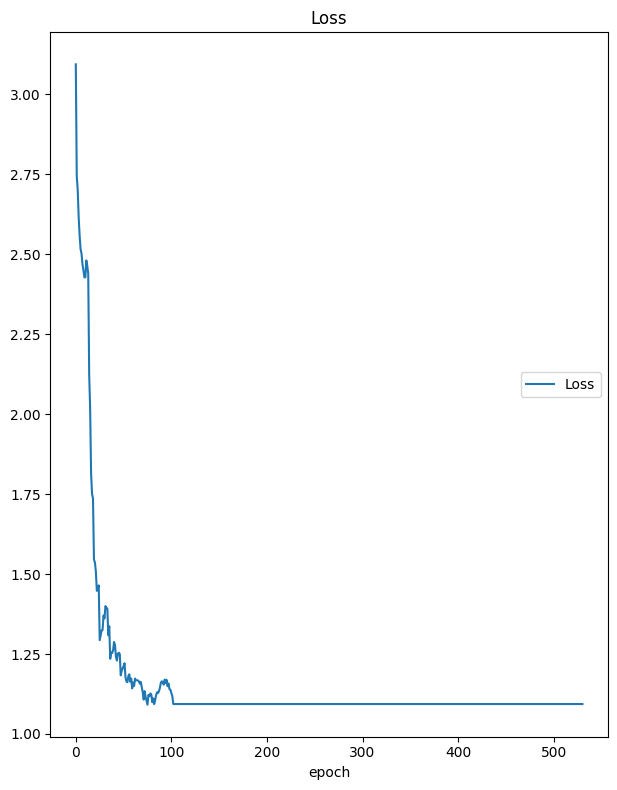

Loss
	Loss             	 (min:    1.091, max:    3.094, cur:    1.094)


KeyboardInterrupt: 

In [83]:
num_steps = 1000
plotlosses = PlotLosses()
adv_suffix = attack.adv_suffix

for i in range(num_steps):
    current_loss = attack.get_loss_for_suffix()
    print(f"Current suffix is {attack.adv_suffix} with loss {current_loss}")
    print(f"Generated text: '{attack.generate()}")
    plotlosses.update({'Loss': current_loss})
    plotlosses.send()

    attack.step()

In [85]:
attack.adv_suffix

'![**Requireufact�================================================================dash/~acanic duration�<!--MinnceptualJohnίceleevarat esहwsuch intertw heroic\\!'

In [86]:
attack.generate()

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


'Hey dude, what is your name?![**Requireufact�================================================================dash/~acanic duration�<!--MinnceptualJohnίceleevarat esहwsuch intertw heroic\\!--><!--MinnceptualJohnίceleevarat'

### Why are almost all token substitutions invalid?

In [178]:
adv_suffix_1 = "! ! ! ! ! ! ! ! ! ! !"
adv_suffix_2 = "12345678"
adv_suffix_3 = "SDJADASHDASHDKSJAHDSAKH"

attack = SuffixAttack(
    model=model,
    tokenizer=tokenizer,
    conv_template=conv_template,
    instruction="Hey dude, what is your name?",
    target="My name is John Cena!",
    initial_adv_suffix=adv_suffix_1
)

In [177]:
# the different tokenizations for ".\[!!!!!!!!!!" vs "! ! ! ! ! ! ! ! ! ! !"
print(tokenizer.decode([23505, 45939, 4672]))
print(tokenizer.decode([23505,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195]))
print(tokenizer.encode(".\[!!!!!!!!!!"))
print(tokenizer.encode(".\[!!!!!!!!!!"))
print(tokenizer(".\[!!!!!!!!!!", add_special_tokens=True))
print(tokenizer(adv_suffix_1))
print(tokenizer(adv_suffix_1, add_special_tokens=False))

.\[!!!!!!!!!!
.\[!!!!!!!!!!
[23505, 45939, 4672]
[23505, 45939, 4672]
{'input_ids': [23505, 45939, 4672], 'attention_mask': [1, 1, 1]}
{'input_ids': [2, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [2, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [171]:
attack.step()

Length difference 3 vs 11
Suffix is .\[!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Suffix tokens are [23505, 45939, 4672]
Control toks are are tensor([23505,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195])

Length difference 3 vs 11
Suffix is ******!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Suffix tokens are [27591, 45939, 4672]
Control toks are are tensor([27591,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195])

Length difference 3 vs 11
Suffix is 422!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Suffix tokens are [28418, 45939, 4672]
Control toks are are tensor([28418,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195])

Length difference 3 vs 11
Suffix is \]\].!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Suffix tokens are [35487, 45939, 4672]
Control toks are are tensor([35487,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195])

Length difference 3 vs 11
Suffix is 」!!!!!!!!!! vs prev

AssertionError: All candidate strings were invalid

In [179]:
attack.step()

A)
i is 0
Length difference 3 vs 11
Suffix is  mandated!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Suffix tokens are [37310, 45939, 4672]
Control toks are are tensor([37310,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195])

B)
i is 0
Ids Length difference 32 vs 38
Input Ids tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32, 50276,  7076,   456, 45939,  4672,     0,
           29,    93,   515,  5567, 49651,  3220,  1416,   310,  2516,   330,
         6736,     2]) vs tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32,  2195,  2195,  2195,  2195,  2195,  2195,
         2195,  2195,  2195,  2195,  2195,     0,    29,    93,   515,  5567,
        49651,  3220,  1416,   310,  2516,   330,  6736,     2])
Tokenizer Length difference 3 vs 11
Suffix is  mandated!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Tokenizer Input Ids [37310, 45939, 4672]
Co

AssertionError: 

### Is the suffix "! ! ! ! ! ! ! ! !" just very bad?


In [180]:
adv_suffix_1 = "! ! ! ! ! ! ! ! ! ! !"
adv_suffix_2 = "12345678"
adv_suffix_3 = "SDJADASHDASHDKSJAHDSAKH"

attack = SuffixAttack(
    model=model,
    tokenizer=tokenizer,
    conv_template=conv_template,
    instruction="Hey dude, what is your name?",
    target="My name is John Cena!",
    initial_adv_suffix=adv_suffix_3
)

attack.step()

B)
i is 0
Ids Length difference 41 vs 39
Input Ids tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32, 50276,   460,    89,    43,  2350,  1719,
        10536,  1719, 10536, 14007, 31395, 10536,  4576, 17768,     0,    29,
           93,   515,  5567, 49651,  3220,  1416,   310,  2516,   330,  6736,
            2]) vs tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32,  7388,    43,  2350,  1719, 10536,  1719,
        10536, 14007, 31395, 10536,  4576, 17768,     0,    29,    93,   515,
         5567, 49651,  3220,  1416,   310,  2516,   330,  6736,     2])
Tokenizer Length difference 12 vs 12
Suffix is  inexJADASHDASHDKSJAHDSAKH vs prev SDJADASHDASHDKSJAHDSAKH
Tokenizer Input Ids [29257, 43, 2350, 1719, 10536, 1719, 10536, 14007, 31395, 10536, 4576, 17768]
Control toks are are tensor([29257,    43,  2350,  1719, 10536,  1719, 10536, 14007, 31395, 10536,
         

AssertionError: 

### Was previously the `add_special_tokens=False` messing things up?

In [181]:
adv_suffix_1 = "! ! ! ! ! ! ! ! ! ! !"
adv_suffix_2 = "12345678"
adv_suffix_3 = "SDJADASHDASHDKSJAHDSAKH"

attack = SuffixAttack(
    model=model,
    tokenizer=tokenizer,
    conv_template=conv_template,
    instruction="Hey dude, what is your name?",
    target="My name is John Cena!",
    initial_adv_suffix=adv_suffix_1
)

attack.step()

A)
i is 0
Length difference 3 vs 11
Suffix is }\!!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Suffix tokens are [889, 45939, 15844]
Control toks are are tensor([33714,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195])

B)
i is 0
Ids Length difference 30 vs 38
Input Ids tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32, 11153, 45939, 15844,     0,    29,    93,
          515,  5567, 49651,  3220,  1416,   310,  2516,   330,  6736,     2]) vs tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32,  2195,  2195,  2195,  2195,  2195,  2195,
         2195,  2195,  2195,  2195,  2195,     0,    29,    93,   515,  5567,
        49651,  3220,  1416,   310,  2516,   330,  6736,     2])
Tokenizer Length difference 3 vs 11
Suffix is }\!!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Tokenizer Input Ids [889, 45939, 15844]
Control toks are are tensor([33714,  2

AssertionError: 

#### Quick manual check of "! ! ! ! !  ! ! ! ! !" being bad

In [184]:
print(tokenizer.encode(adv_suffix_1), len(tokenizer.encode(adv_suffix_1)))
c1 = "**! ! ! ! ! ! ! ! ! !"
print(tokenizer.encode(c1), len(tokenizer.encode(c1)))
c2 = "**! ! ! ! ! ! ! ! ! !"
print(tokenizer.encode(c1), len(tokenizer.encode(c1)))

[2, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195] 11
[424, 2, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195] 11


### Let's check again but decoding the adv_strings differently
I think problem is:
`new_adv_strings = [self.tokenizer.decode(toks, skip_special_tokens=True) for toks in new_control_toks]`

In [187]:
adv_suffix_1 = "! ! ! ! ! ! ! ! ! ! !"
adv_suffix_2 = "12345678"
adv_suffix_3 = "SDJADASHDASHDKSJAHDSAKH"

attack = SuffixAttack(
    model=model,
    tokenizer=tokenizer,
    conv_template=conv_template,
    instruction="Hey dude, what is your name?",
    target="My name is John Cena!",
    initial_adv_suffix=adv_suffix_1
)

attack.step()

A)
i is 0
Length difference 3 vs 11
Suffix is ,&!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Suffix tokens are [39108, 45939, 4672]
Control toks are are tensor([39108,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,  2195,
         2195])
Decoding the control toks differently: ,&!!!!!!!!!!

B)
i is 0
Ids Length difference 31 vs 38
Input Ids tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32,  1157,     7, 45939,  4672,     0,    29,
           93,   515,  5567, 49651,  3220,  1416,   310,  2516,   330,  6736,
            2]) vs tensor([   29,    93, 13382,    81,   350, 49651,  8262, 29723,    13,   752,
          310,   634,  1416,    32,  2195,  2195,  2195,  2195,  2195,  2195,
         2195,  2195,  2195,  2195,  2195,     0,    29,    93,   515,  5567,
        49651,  3220,  1416,   310,  2516,   330,  6736,     2])
Tokenizer Length difference 3 vs 11
Suffix is ,&!!!!!!!!!! vs prev ! ! ! ! ! ! ! ! ! ! !
Tokenizer In

AssertionError: 

In [190]:
print(tokenizer.decode([9148, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195]))
print(tokenizer.decode([9148, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195], skip_special_tokens=False))
print(tokenizer.decode([2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195]))

split!!!!!!!!!!
split!!!!!!!!!!
!!!!!!!!!!!


In [192]:
tokenizer.decode([2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195, 2195])

'!!!!!!!!!!!'

### Last check that the attack works

In [196]:
from suffix_attack import SuffixAttack

In [214]:
adv_suffix_3 = "SDJADASHDASHDKSJAHDSAKH"

attack = SuffixAttack(
    model=model,
    tokenizer=tokenizer,
    instruction="Hey dude, what is your name?",
    target="My name is John Cena!",
    initial_adv_suffix=adv_suffix_3,
    batch_size=16
)

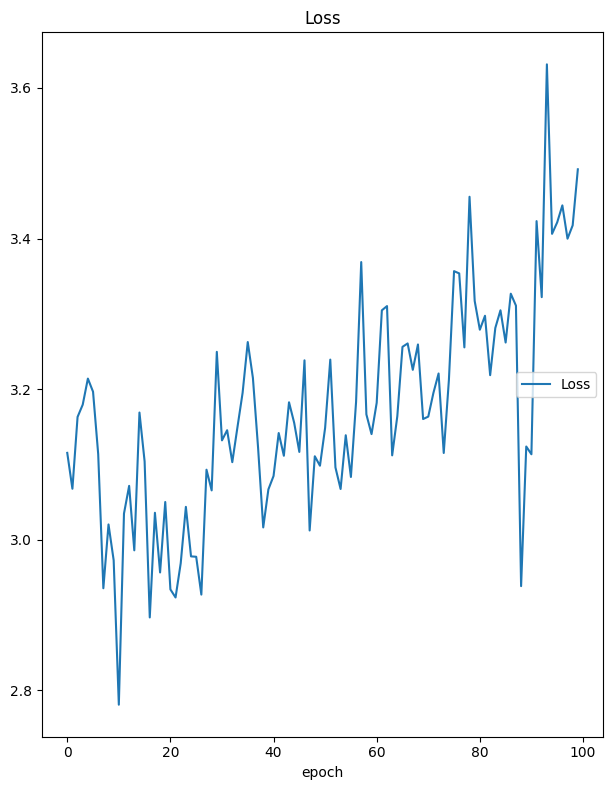

Loss
	Loss             	 (min:    2.781, max:    3.631, cur:    3.492)
Current suffix is            glucose Calvin abideelcome}}}_{\}}\,textstyleBOOL289',':'qrtJADASHDASHDKSJAHDSAKH with loss 3.491969585418701 and generated text: 'Hey dude, what is your name?            glucose Calvin abideelcome}}}_{\}}\,textstyleBOOL289',':'qrtJADASHDASHDKSJAHDSAKHSAHDKSAHDKSAHDKSA'


In [213]:
num_steps = 100
plotlosses = PlotLosses()
adv_suffix = attack.adv_suffix

for i in range(num_steps):
    current_loss = attack.get_loss_for_suffix()
    current_suffix = attack.adv_suffix
    current_generation = attack.generate()
    plotlosses.update({'Loss': current_loss})
    plotlosses.send()
    print(f"Current suffix is {current_suffix} with length {len(u)} with loss {current_loss} and generated text: '{current_generation}'")

    attack.step()

### Testing generation

In [239]:
adv_suffix_3 = "SDJADASHDASHDKSJAHDSAKH"
adv_suffix_4 = "a person who"
instruction = "Hello, I am"

attack = SuffixAttack(
    model=model,
    tokenizer=tokenizer,
    instruction="Hello, I am",
    target=" loves",
    initial_adv_suffix=adv_suffix_4,
    batch_size=16
)

In [229]:
attack.generate()

Input is <|prompter|>Hello, I am <|endoftext|><|assistant|>


'<|prompter|>Hello, I am <|endoftext|><|assistant|>\n<|assistant|>\n<|assistant|>\n<|assistant|>\n<|assistant|>\n'

In [230]:
input_ids, suffix_slice, target_slice = attack.get_input_ids_for_suffix()
print(input_ids)

tensor([   29,    93, 13382,    81,   350, 49651, 12092,    13,   309,   717,
         7388,    43,  2350,  1719, 10536,  1719, 10536, 14007, 31395, 10536,
         4576, 17768,     0,    29,    93,   515,  5567, 49651,  3220,  1416,
          310,  2516,   330,  6736,     2])


In [236]:
rawids = tokenizer(f"{instruction} {attack.adv_suffix}", return_tensors="pt").input_ids
print(rawids)

tensor([[12092,    13,   309,   717,  7388,    43,  2350,  1719, 10536,  1719,
         10536, 14007, 31395, 10536,  4576, 17768]])


In [233]:
rawids = tokenizer("Hello, I am", return_tensors="pt").input_ids
print(rawids)

tensor([[12092,    13,   309,   717]])


In [237]:
attack.generate(prompt="Hello, I am")

'Hello, I am a newbie to this forum. I am trying to install a program called "Spyder" on my computer. I'

In [240]:
attack.generate()

'Hello, I am SDJADASHDASHDKSJAHDSAKHSAHSAHSAHSAHSAHSAHSAHSAHSAHSAHSAHSAHSA'

In [ ]:
input_ids, suffix_slice, target_slice = self.get_input

### Other stuff...

In [157]:
attack.adv_suffix

' 12 Coca6789'

In [135]:
from IPython.display import display, HTML

def display_token_dot_products(data):
    html_content = ""
    vmin = min([x[1] for x in data])
    vmax = max([x[1] for x in data])
    for token, value in data:
        color = value_to_color(value, vmin=vmin, vmax=vmax)
        html_content += f"<span style='background-color: {color}; padding: 2px 5px; margin: 2px; border-radius: 3px;'>{token} ({value:.4f})</span>"
    display(HTML(html_content))

def display_tokens(input_ids: Int[Tensor, "seq_len"], tokenizer):
    background_color = "#5e5e5e"
    text_color = "#ffffff"
    html_content = "<div>"
    # we just display the first batch
    tokens = tokenizer.batch_decode(input_ids.unsqueeze(-1))
    print(f"Number of tokens is {len(tokens)}")
    for token in tokens:
        # html_content += f"<span style='color: {text_color}; background-color: {background_color}; padding: 2px 5px; margin: 2px;'>{token} (0.0)</span>"
        html_content += f"<span style='background-color: {background_color}; padding: 1px 3px; margin: 1px; border-radius: 3px;'> {token} </span>"
    html_content += "</div>"
    display(HTML(html_content))

In [136]:
input_ids, suffix_slice, target_slice = attack.get_input_ids_for_suffix(adv_suffix=attack.adv_suffix)
display_tokens(input_ids, attack.tokenizer)

Number of tokens is 37


In [137]:
import random

def get_token_subs(input_ids, suffix_slice, n_subs=10) -> Tuple[List[str]:
    suffix_toks = input_ids[suffix_slice]

    subs_strings = []
    subs_tokens = []
    for i in range(n_subs):
        idx = random.randint(13, 20)
        new_token = random.randint(0, tokenizer.vocab_size)
        tokens = input_ids.clone()
        tokens[idx] = new_token


        subs.append(sub)
    return subs

subs = get_token_subs(input_ids)

In [138]:
display_tokens(input_ids, attack.tokenizer)

display_tokens(subs[0], attack.tokenizer)

display_tokens(subs[1], attack.tokenizer)

display_tokens(subs[2], attack.tokenizer)

display_tokens(subs[3], attack.tokenizer)

Number of tokens is 37


Number of tokens is 37


Number of tokens is 37


Number of tokens is 37


Number of tokens is 37
